# Making inference with pretrained UNet and B-UNet models

Define functions and set up environment

In [37]:
import torch
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import ants
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dataloaders import get_synth_dhcp_dataloader, get_synth_hcp_dataloader
import torchio as tio

from utils.inference_utils import *

from ipywidgets import interact, fixed
from IPython.display import clear_output

In [38]:
model_t1 = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-dhcp-1550.pth')
model_t1_aug = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-dhcp-aug-1520.pth')
model_t2 = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-dhcp-aug-1520.pth')
model_t2_aug = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-dhcp-aug-1520.pth')

mu_t1 = model_t1.enc_mu[0].flatten()
logvar_t1 = model_t1.enc_logvar[0].flatten()
mu_t2 = model_t2.enc_mu[0].flatten()
logvar_t2 = model_t2.enc_logvar[0].flatten()

### Debug

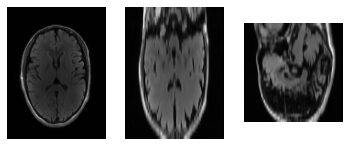

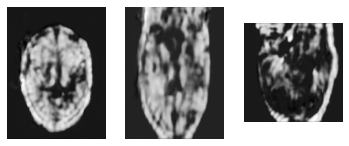

interactive(children=(IntSlider(value=108, description='image_z', max=324, min=-108), Output()), _dom_classes=…

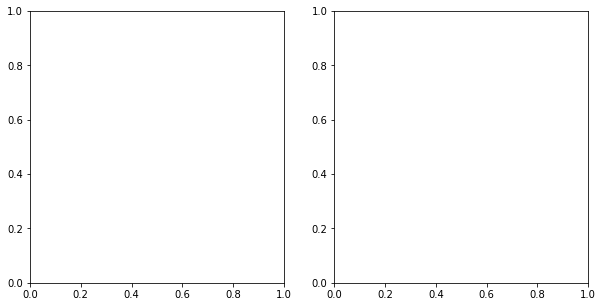

In [136]:
image_path = "/media/hdd/viscent/SR-UNet/inference/Yiqi_FLAIR.nii.gz"
image = sitk.ReadImage(image_path)
image = resample(image)
image_array = sitk.GetArrayFromImage(image).astype(np.float32)
image_tensor = torch.from_numpy(image_array).unsqueeze(0).unsqueeze(0).cuda()
output_tensor = model_vae_hcp(image_tensor)
output_array = output_tensor.detach().cpu().numpy()[0,0]
display_multiplanar(image_array)
display_multiplanar(output_array)
interact(
    display_images,
    image_z=image_array.shape[2],
    image_0=fixed(image_array),
    image_1=fixed(output_array),
);

### T1

In [4]:
image_tensor,target_tensor = load_image()

mse: 0.26230386
kl: 125175.92780204528
Free energy: 31.556285809506758


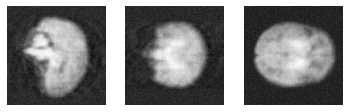

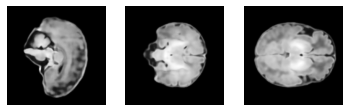

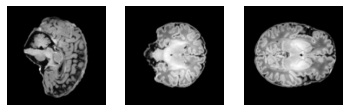

In [18]:
output_tensor = infer(model_t1,image_tensor)
get_metrics(output_tensor,target_tensor,model_t1, mu_q= mu_t1, logvar_q= logvar_t1)
display_multiplanar(image_tensor.detach().cpu().numpy()[0,0])
display_multiplanar(output_tensor.detach().cpu().numpy()[0,0])
display_multiplanar(target_tensor.detach().cpu().numpy()[0,0])
dhcp_tensor = output_tensor.clone()
rsqe_t1 = (output_tensor - target_tensor).pow(2).sqrt()
rsqe_t1 = rsqe_t1.detach().cpu().numpy()[0,0]

### T1-Augmented

mse: 0.401928
kl: 71836.07399219225
Free energy: 18.360946505650755


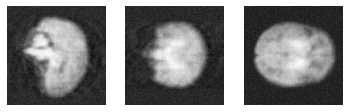

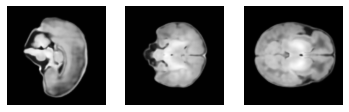

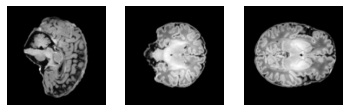

In [19]:
output_tensor = infer(model_t1_aug,image_tensor)
get_metrics(output_tensor,target_tensor,model_t1_aug, mu_q= mu_t1, logvar_q= logvar_t1)
display_multiplanar(image_tensor.detach().cpu().numpy()[0,0])
display_multiplanar(output_tensor.detach().cpu().numpy()[0,0])
display_multiplanar(target_tensor.detach().cpu().numpy()[0,0])
dhcp_tensor = output_tensor.clone()
rsqe_t1_aug = (output_tensor - target_tensor).pow(2).sqrt()
rsqe_t1_aug = rsqe_t1_aug.detach().cpu().numpy()[0,0]

### Error-T1

/tmp/ipykernel_807666/339122276.py:14: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6



<Figure size 432x288 with 0 Axes>

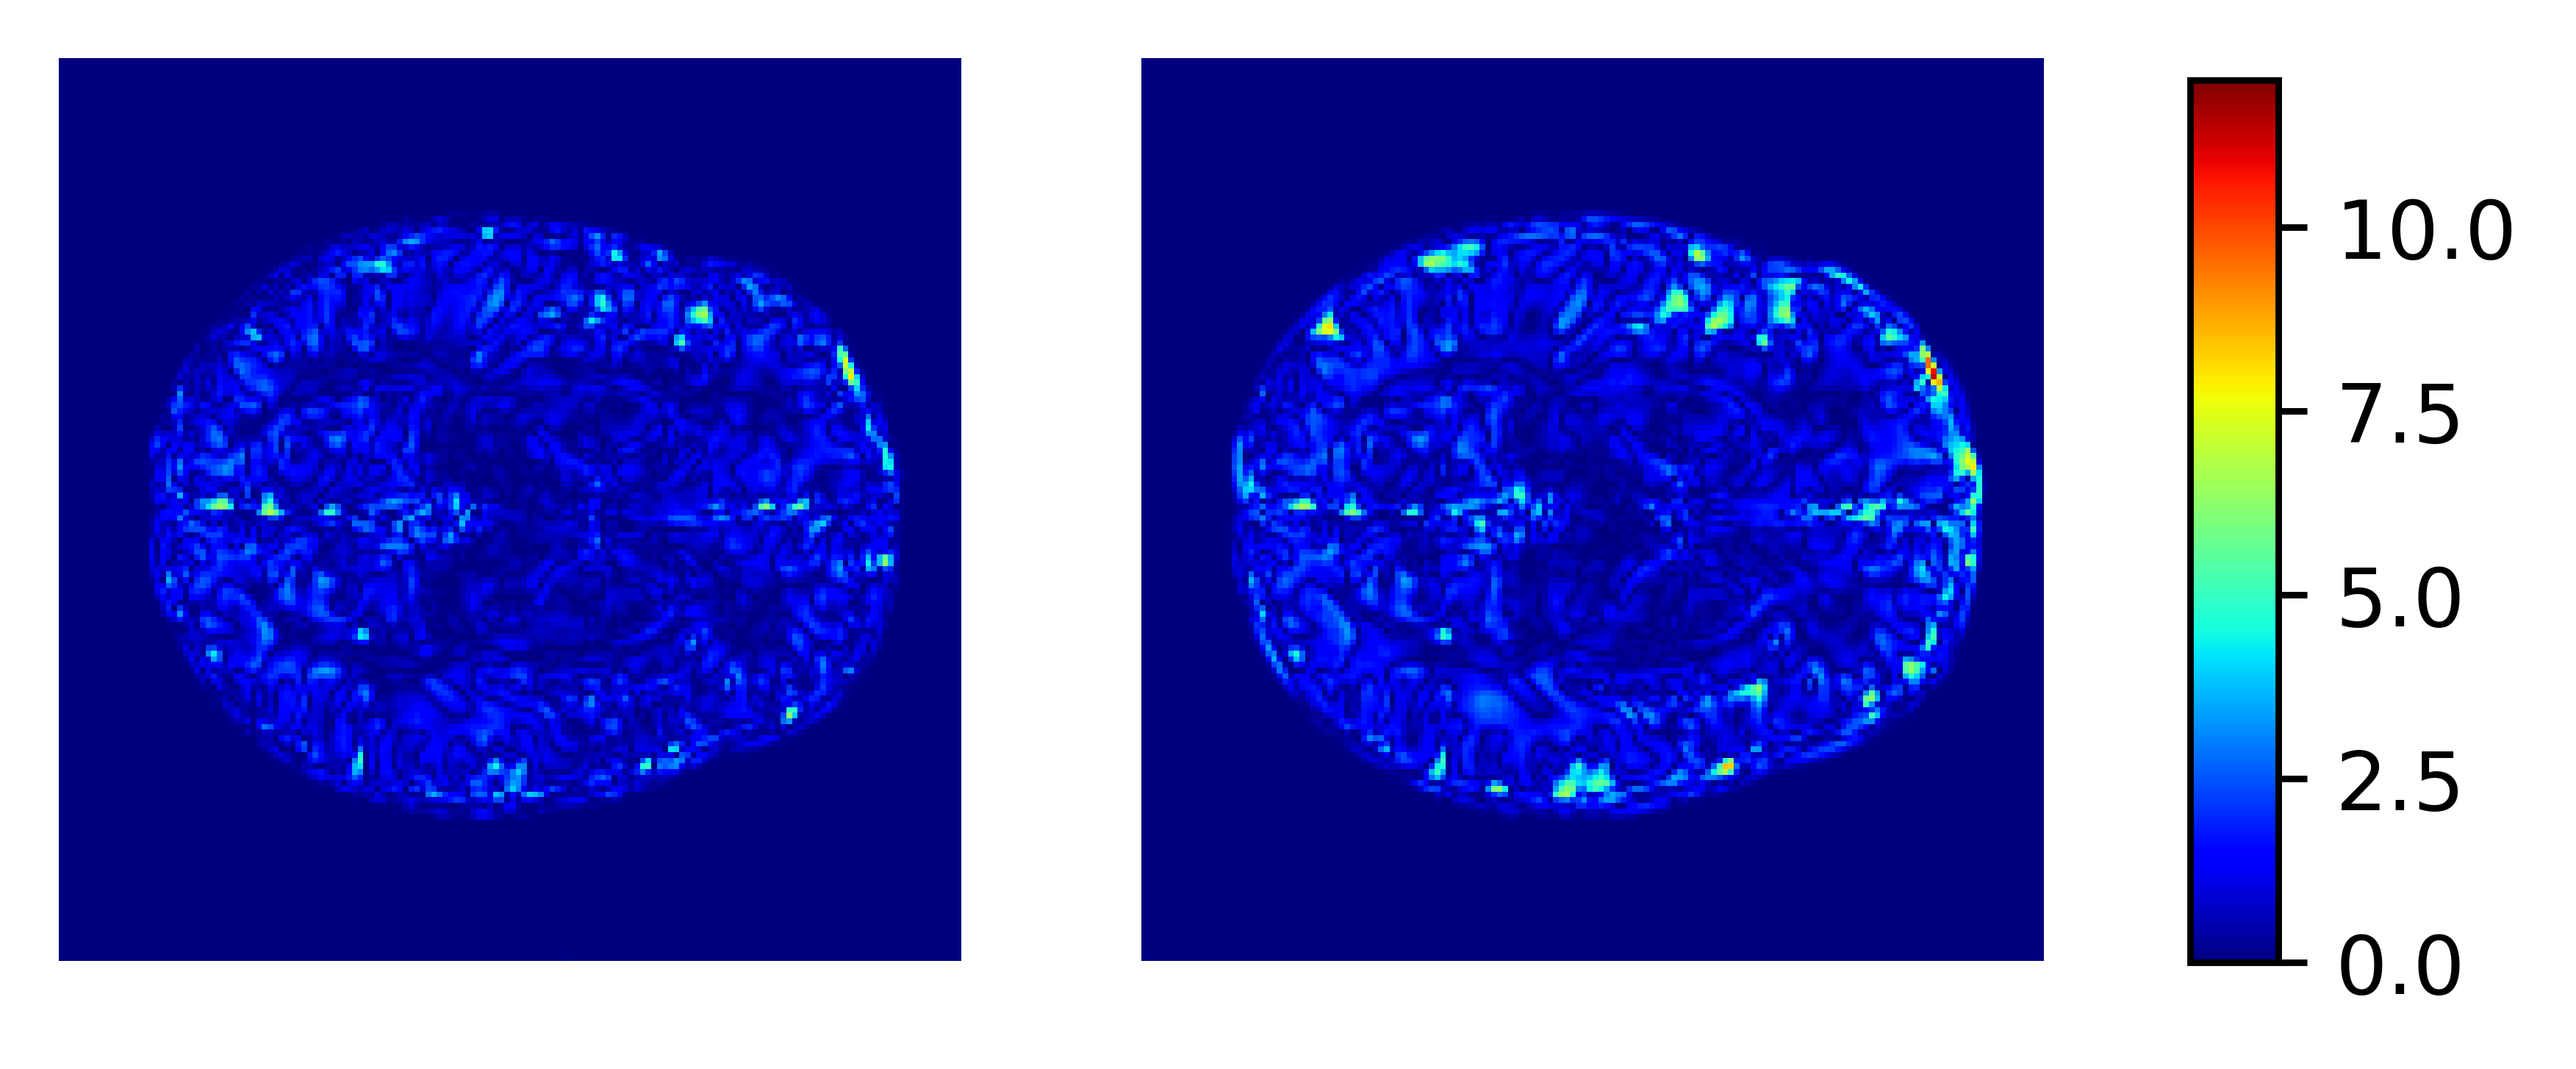

In [13]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,10), dpi = 800)
array_dhcp = rsqe_t1[::-1,:,rsqe_t1.shape[2]//2]
array_hcp = rsqe_t1_aug[::-1,:,rsqe_t1_aug.shape[2]//2]
zlim = (0,max(np.abs(rsqe_t1).max(), np.abs(rsqe_t1_aug).max()))
im1 = ax1.imshow(array_dhcp, cmap='jet', vmin=zlim[0], vmax=zlim[1])
im2 = ax2.imshow(array_hcp, cmap='jet', vmin=zlim[0], vmax=zlim[1])
ax1.axis('off')
ax2.axis('off')
#add colorbar
fig.subplots_adjust(right=0.8)
cbax = fig.add_axes([0.85, 0.4255, 0.03, 0.15])
fig.colorbar(im1, ax=[ax1, ax2], cax=cbax)
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/dHCP_error.png", dpi=800, Transparent=True)

### T2

In [42]:
t2_loader,_,_ = get_dataloader(dataset='dhcp', num_samples=100,modality='t2')
image_tensor,target_tensor = next(iter(t2_loader))
image_tensor = image_tensor.cuda()
target_tensor = target_tensor.cuda()

[08/30/22 16:01:02] INFO     colossalai - root - INFO: Creating dataset with 80 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 80

  0%|          | 0/80 [00:00<?, ?it/s]

[08/30/22 16:01:04] INFO     colossalai - root - INFO: Creating dataset with 20 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 20

  0%|          | 0/20 [00:00<?, ?it/s]

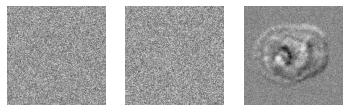

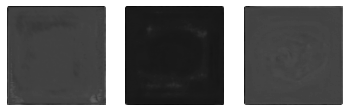

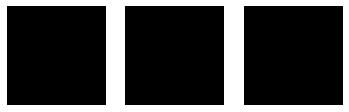

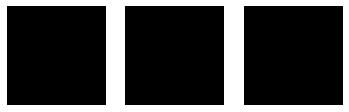

In [56]:
image_tensor,target_tensor = next(iter(t2_loader))
image_tensor = image_tensor.cuda()
target_tensor = target_tensor.cuda()

output_tensor = infer(model_t2,image_tensor)
display_multiplanar(image_tensor.detach().cpu().numpy()[0,0])
display_multiplanar(output_tensor.detach().cpu().numpy()[0,0])
display_multiplanar(target_tensor.detach().cpu().numpy()[0,0])

### T2-Augmented

mse: 3.0474098
kl: 53986.48582998439
Free energy: 16.544031230369022


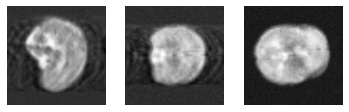

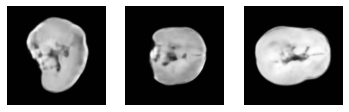

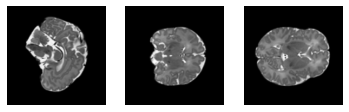

In [36]:
output_tensor = infer(model_t2_aug,image_tensor)
get_metrics(output_tensor,target_tensor,model_t2_aug)
display_multiplanar(image_tensor.detach().cpu().numpy()[0,0])
display_multiplanar(output_tensor.detach().cpu().numpy()[0,0])
display_multiplanar(target_tensor.detach().cpu().numpy()[0,0])